In [1]:
!pip install torchsummary

In [2]:
import os
import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn

from torchsummary import summary

In [3]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

--2020-02-14 11:20:35--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  95.6MB/s    in 1.7s    

2020-02-14 11:20:37 (95.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

/kaggle/working/cifar-10-python.tar.gz
/kaggle/working/__notebook__.ipynb


In [4]:
!tar -xvf /kaggle/working/cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [5]:
!rm -rf /kaggle/working/cifar-10-python.tar.gz
!ls /kaggle/working/cifar-10-batches-py

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [6]:
DATA_DIR = '/kaggle/working/cifar-10-batches-py'

## Let's explore the data format

The complete details of format of the data is given [here](https://www.cs.toronto.edu/~kriz/cifar.html). 

In [7]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
metadata = unpickle(os.path.join(DATA_DIR, 'batches.meta'))[b'label_names']
metadata = [m.decode('utf-8') for m in metadata]
metadata

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
data_batch_1 = unpickle(os.path.join(DATA_DIR, 'data_batch_1'))
list(data_batch_1.keys())

[b'batch_label', b'labels', b'data', b'filenames']

In [10]:
print(f"Batch label: {data_batch_1[b'batch_label']}")
print(f"Shape of Labels: {len(data_batch_1[b'labels'])}")
print(f"Actual image data shape: {data_batch_1[b'data'].shape}")
print(f"Filenames: {len(data_batch_1[b'filenames'])}")

Batch label: b'training batch 1 of 5'
Shape of Labels: 10000
Actual image data shape: (10000, 3072)
Filenames: 10000


The return dict contains following keys:

* **batch_label:** The label of batch
* **labels:** Labels of given images in `data` key for training
* **data:** Flattened colored images for training
* **filename:** Names of file from the image is read (Useless in our case)

In [11]:
def load_data(data_type='TRAIN'):
    X, Y = [], []
    if data_type == 'TRAIN':
        for i in range(5):
            batch = unpickle(os.path.join(DATA_DIR, f'data_batch_{i+1}'))
            X.append(batch[b'data'])
            Y.append(batch[b'labels'])
    else:
        test_batch = unpickle(os.path.join(DATA_DIR, f'test_batch'))
        X.append(test_batch[b'data'])
        Y.append(test_batch[b'labels'])

    return torch.from_numpy(np.concatenate(np.array(X), axis=0)), torch.from_numpy(np.concatenate(np.array(Y), axis=0))

In [12]:
X_train, Y_train = load_data()
X_test, Y_test = load_data('TEST')

## Exploratory Data Analysis

In [13]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of Y_train: {Y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of Y_test: {Y_test.shape}')

Shape of X_train: torch.Size([50000, 3072])
Shape of Y_train: torch.Size([50000])
Shape of X_test: torch.Size([10000, 3072])
Shape of Y_test: torch.Size([10000])


From the above results, we've 50k training images and 10k testing images. Training images will be further splitted into training and validation images.

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train.cpu().detach().numpy(), Y_train.cpu().detach().numpy(), test_size=0.1, random_state=666)

In [15]:
# Convert to PyTorch tensor
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
Y_train = torch.from_numpy(Y_train)
Y_val = torch.from_numpy(Y_val)

In [16]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of Y_train: {Y_train.shape}')
print(f'Shape of X_test: {X_val.shape}')
print(f'Shape of Y_test: {Y_val.shape}')

Shape of X_train: torch.Size([45000, 3072])
Shape of Y_train: torch.Size([45000])
Shape of X_test: torch.Size([5000, 3072])
Shape of Y_test: torch.Size([5000])


In [17]:
IMG_SIZE = 32
CHANNELS = 3
W, H = IMG_SIZE, IMG_SIZE

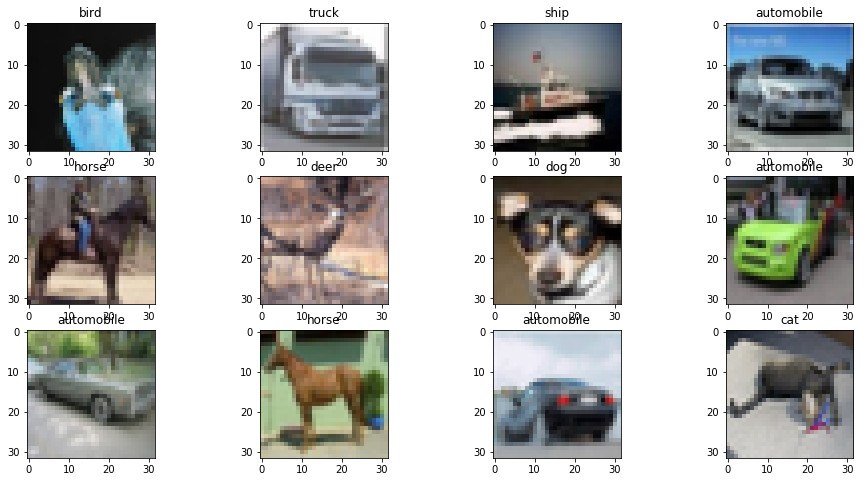

In [18]:
# Visualize few samples of training dataset
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
count=0
for row in ax:
    for col in row:
        col.imshow(torch.stack([X_train[count, :][:1024].reshape(IMG_SIZE, IMG_SIZE), X_train[count, :][1024: 2048].reshape(IMG_SIZE, IMG_SIZE), X_train[count, :][2048:].reshape(IMG_SIZE, IMG_SIZE)], axis=2))
        col.set_title(metadata[Y_train[count]])
        count += 1
plt.show()

### Distribution of class

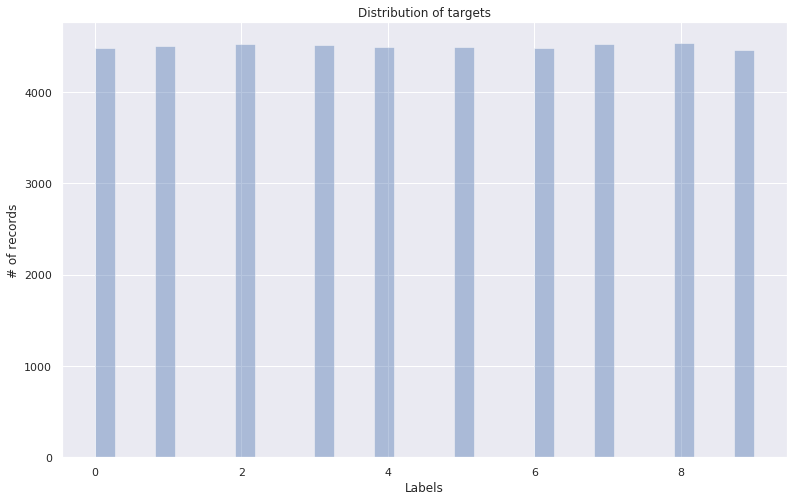

In [19]:
sns.set(rc={'figure.figsize':(13,8)})
ax = sns.distplot(Y_train, kde=False)
ax.set(xlabel='Labels', ylabel='# of records', title='Distribution of targets')
plt.show()

There are 5000 records for all 10 classes of images.

## Creating custom PyTorch data generator and Data Loader

References: 

* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* https://github.com/utkuozbulak/pytorch-custom-dataset-examples
* https://stackoverflow.com/questions/41924453/pytorch-how-to-use-dataloaders-for-custom-datasets


In [20]:
class CFAR10Dataset(Dataset):
    """
    Custom CIFAR-10 dataset
    """
    def __init__(self, X, Y, transforms=None):
        self.X = X
        self.Y = Y
        self.transforms = transforms
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        image = torch.stack([self.X[index, :][:1024].reshape(IMG_SIZE, IMG_SIZE), self.X[index, :][1024: 2048].reshape(IMG_SIZE, IMG_SIZE), self.X[index, :][2048:].reshape(IMG_SIZE, IMG_SIZE)], axis=2).permute(2, 1, 0).float()/255
        if self.transforms:
            image = self.transforms(image)
        return image, self.Y[index]

In [21]:
batch_size=3000

### Define data augmentations using pytorch transforms

In [22]:
transformations = transforms.Compose([transforms.CenterCrop(100),
                                      transforms.ToTensor()])

In [23]:
train_dataset = CFAR10Dataset(X_train, Y_train)
train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Basic CNN Model using PyTorch

Let's create a CNN model. Architecture reference: https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn

In [24]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),                           
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5, 5), padding=2),
            nn.ReLU(True),
            nn.Dropout2d(p=0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), padding=2),
            nn.ReLU(True),
            nn.Dropout2d(p=0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), padding=2),
            nn.ReLU(True),
            nn.Dropout2d(p=0.3)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=256),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(5, 5), padding=2),
            nn.ReLU(True),
            nn.Dropout2d(p=0.3)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=1024, out_features=1024)
        self.fc1_dropout = nn.Dropout2d(p=0.3)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)
        
        
    def forward(self, X):
        output = self.layer1(X)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.flatten(output)
        output = self.fc1(output)
        output = self.fc1_dropout(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
model = Model().to(device)

# Print summary of our model
summary(model, input_size=(CHANNELS, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,248
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]          25,632
             ReLU-12           [-1, 32, 16, 16]               0
        Dropout2d-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 64,

In [27]:
LEARNING_RATE = 0.1
EPOCHS = 100
CLASSES = 10
CUTMIX_ALPHA = 1

In [28]:
model = nn.DataParallel(model)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

https://discuss.pytorch.org/t/multi-class-classifier/29901/2

In [29]:
X_val.shape
X_val_list = []
for x in X_val:
    X_val_list.append((torch.stack([x[:1024].reshape(IMG_SIZE, IMG_SIZE), x[1024: 2048].reshape(IMG_SIZE, IMG_SIZE), x[2048:].reshape(IMG_SIZE, IMG_SIZE)], axis=2).permute(2, 1, 0).float()/255))
X_val = torch.stack(X_val_list)

In [30]:
def get_accuracy(preds, actual):
    assert len(preds) == len(actual)
    
    total = len(actual)
    _, predicted = torch.max(preds.data, axis=1)
    correct = (predicted == actual).sum().item()
    return correct / total

In [31]:
def shuffle_minibatch(x, y):
    assert x.size(0)== y.size(0)
    indices = torch.randperm(x.size(0))
    return x[indices], y[indices]

In [32]:
total_steps = len(train_loader)
loss_list, train_acc_list, val_acc_list = [], [], []
plot_flag = False
for epoch in range(EPOCHS):
    for i, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        cutmix_decision = np.random.rand()
        if cutmix_decision > 0.50:
            # Cutmix: https://arxiv.org/pdf/1905.04899.pdf
            x_train_shuffled, y_train_shuffled = shuffle_minibatch(x_train, y_train)
            lam = np.random.beta(CUTMIX_ALPHA, CUTMIX_ALPHA)
            cut_rat = np.sqrt(1. - lam)
            cut_w = np.int(W * cut_rat)
            cut_h = np.int(H * cut_rat)

            # uniform
            cx = np.random.randint(W)
            cy = np.random.randint(H)

            bbx1 = np.clip(cx - cut_w // 2, 0, W)
            bby1 = np.clip(cy - cut_h // 2, 0, H)
            bbx2 = np.clip(cx + cut_w // 2, 0, W)
            bby2 = np.clip(cy + cut_h // 2, 0, H)

            x_train[:, :, bbx1:bbx2, bby1:bby2] = x_train_shuffled[:, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - (bbx2 - bbx1) * (bby2 - bby1) / (W * H)
        
        # Forward pass
        y_preds = model(x_train)
        
        # Calculate loss
        if cutmix_decision > 0.50:
            loss = criterion(y_preds, y_train) * lam + criterion(y_preds, y_train_shuffled) * (1. - lam)
        else:
            loss = criterion(y_preds, y_train)
        if i+1 == total_steps:
            loss_list.append(loss)
        
        # Backpropagate
        optimizer.zero_grad()  # Reason: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        loss.backward()
        optimizer.step()
        
        # Calculate the accuracy
        train_acc = get_accuracy(y_preds, y_train)
        if i+1 == total_steps:
            train_acc_list.append(train_acc)
            
        # Calculate validation accuracy
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)
        
        # Predict on validation set
        val_preds = model(X_val)
        
        val_acc = get_accuracy(val_preds, Y_val)
        if i+1 == total_steps:
            val_acc_list.append(val_acc)

        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train accuracy: {:.2f}%, Validation accuracy: {:.2f}%'
                  .format(epoch + 1, EPOCHS, i + 1, total_steps, loss.item(),
                          train_acc * 100, val_acc * 100))
    print()

Epoch [1/100], Step [10/15], Loss: 2.2571, Train accuracy: 12.17%, Validation accuracy: 18.94%

Epoch [2/100], Step [10/15], Loss: 2.1228, Train accuracy: 20.57%, Validation accuracy: 21.56%

Epoch [3/100], Step [10/15], Loss: 2.1900, Train accuracy: 17.83%, Validation accuracy: 23.16%

Epoch [4/100], Step [10/15], Loss: 2.1052, Train accuracy: 18.90%, Validation accuracy: 21.46%

Epoch [5/100], Step [10/15], Loss: 1.9794, Train accuracy: 23.80%, Validation accuracy: 19.88%

Epoch [6/100], Step [10/15], Loss: 2.2357, Train accuracy: 20.43%, Validation accuracy: 27.92%

Epoch [7/100], Step [10/15], Loss: 2.2517, Train accuracy: 12.07%, Validation accuracy: 27.20%

Epoch [8/100], Step [10/15], Loss: 1.9221, Train accuracy: 29.50%, Validation accuracy: 29.56%

Epoch [9/100], Step [10/15], Loss: 1.8367, Train accuracy: 30.20%, Validation accuracy: 29.44%

Epoch [10/100], Step [10/15], Loss: 1.7923, Train accuracy: 30.20%, Validation accuracy: 29.70%

Epoch [11/100], Step [10/15], Loss: 2.1

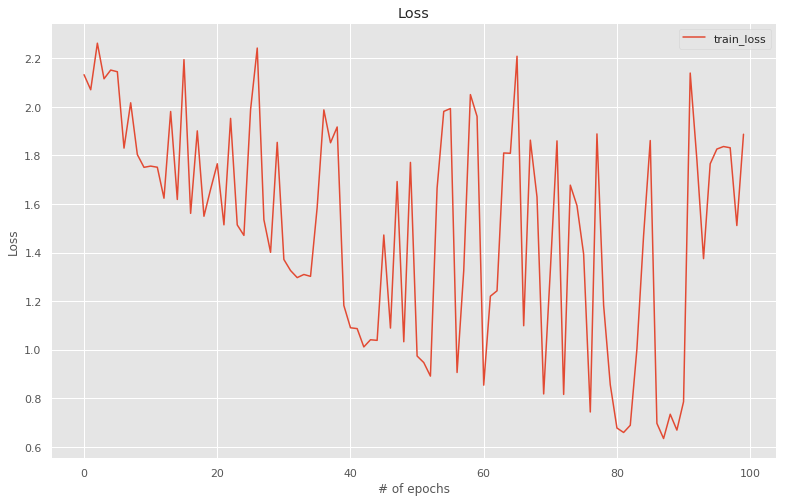

In [33]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, EPOCHS), loss_list, label='train_loss')

plt.title('Loss')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

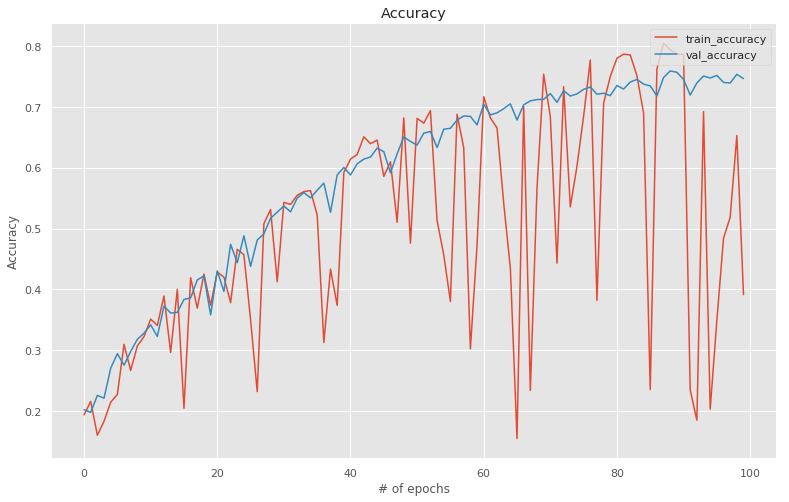

In [34]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, EPOCHS), train_acc_list, label='train_accuracy')
plt.plot(np.arange(0, EPOCHS), val_acc_list, label='val_accuracy')

plt.title('Accuracy')
plt.xlabel('# of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()